# Importing libraries

In [1]:
from matplotlib import pyplot

from pyspark.sql import functions
from pyspark.sql import types

from pyspark.sql import SparkSession
from pyspark.sql import Window

from pyspark.ml.linalg import Vectors 
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import OneVsRest

from pandas import DataFrame

from seaborn import heatmap

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Creating Session

In [2]:
spark = SparkSession \
    .builder \
    .appName('ImageClassification') \
    .getOrCreate()

# Data cleaning

## Reading JSON

In [3]:
# [(x, y)]
# x -> path (/directory/filename.extension)
# y -> content ('[values]\n')
# [(path, content)]
rdd = spark.sparkContext.wholeTextFiles('../datasets/dogs/json') 

## Transforming DataFrame

In [4]:
df = spark.createDataFrame(rdd, ['path', 'features'])

### Splitting string to array

In [5]:
df = df \
    .withColumn('features', functions.regexp_replace('features', '[\[\s\]]', '')) \
    .withColumn('features', functions.split('features', ',')) \
    .withColumn('features', functions.col('features').cast(types.ArrayType(types.FloatType()))) \
    .withColumn('features', functions.udf(lambda row: Vectors.dense(row), VectorUDT())('features'))

### Getting filename from path

In [6]:
df = df.withColumn('filename', functions.regexp_extract('path', '([^\/])+(?=\_(\d+).+)', 0))

### Getting breed from filename

In [7]:
df = df \
    .withColumn('breed', functions.trim('filename')) \
    .withColumn('breed', functions.lower('breed'))    

### Indexing filename as label

In [8]:
df = df.join(df[['filename']] \
            .distinct() \
            .withColumn('label', functions.row_number().over(Window.orderBy('filename')) - 1),
        ['filename'],
        how='left') \
    .withColumn('label', functions.col('label').cast(types.BooleanType())) \
    .withColumn('label', functions.col('label').cast(types.IntegerType()))

# Binary classification

## Splitting DataFrame

In [9]:
df_train = df.sampleBy('label', {0: 0.2, 1: 0.2})
df_test = df.join(df_train, ['path'], how='left_anti')

## Training model

In [10]:
model = OneVsRest(classifier=LogisticRegression(featuresCol='features', labelCol='label')) \
    .fit(df_train) # creating model

# Predicting

In [11]:
df_predictions = model.transform(df_test)

## Confusion Matrix

In [12]:
df_data = df_predictions[['breed', 'filename', 'label', 'prediction']].toPandas()

In [13]:
df_data.loc[df_data['label']>0, 'filename'] = 'other'

In [14]:
matrix = confusion_matrix(df_data['label'], df_data['prediction'])

In [15]:
columns = df_data.sort_values('label')['filename'].unique()

### Plotting Confusion Matrix

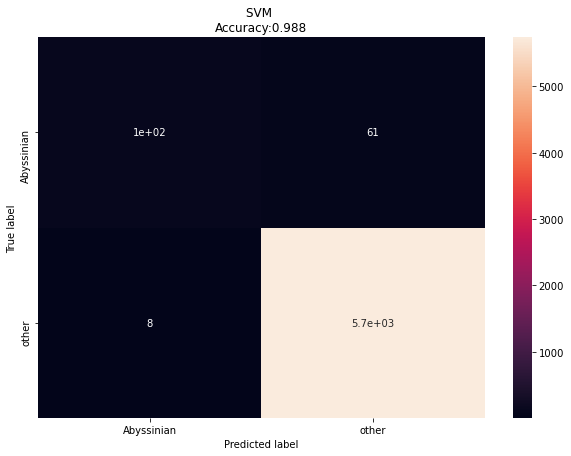

In [16]:
pyplot.figure(figsize=(10,7))

heatmap(DataFrame(matrix, index=columns, columns=columns), annot = True)

pyplot.title('SVM \nAccuracy:{0:.3f}'.format(accuracy_score(df_data['label'], df_data['prediction'])))
pyplot.ylabel('True label')
pyplot.xlabel('Predicted label')
pyplot.show()